## Function definitions

##### Reads .eig file eigFileName

- returns the list of complex eigenvalues sorted according to their absolute values `evs.sort(key = abs)`
- CDF means Complex Double Field

In [1]:
def readCEVs(eigFileName):
# eigFileName - name of .eig file with eigenvalues
    f = open(eigFileName, "r")
    cevs = []
    for line in f:
        s = line.split()
        cevs.append(CDF(float(s[0]), float(s[1])))
    f.close()
    cevs.sort(key = abs)
    return cevs

In [2]:
def readAllCEVs(eigFilesList):
# eigFilesList - list of .eig file names
    f = open(eigFilesList, "r")
    allCEVs = []
    for eigFileName in f:
        allCEVs.append(readCEVs(eigFileName.strip()))
    f.close()
    return allCEVs

In [3]:
def eigPlot(cevs):
    return list_plot([[cev.real(), cev.imag()] for cev in cevs], aspect_ratio = 1)

In [4]:
def countZeros(cevs):
    return len([cev for cev in cevs if abs(cev) < 1e-12 ])

In [5]:
def detM(cevs, qm, normalization, out):
# function detM() computes determinant of the massive overalap Dirac operator
# cevs - list of eigenvalues (CDF)
# qm - quark mass
# normalization - number usually smaller than one which prevents determinant growing too large
# out - if True final product p is printed (imaginary part of p should be near zero)
    one = CDF(1, 0)
    half = CDF(0.5, 0)
    nmz = CDF(normalization, 0)
    p = one # product
    for i in range(len(cevs)):
        p *= ((one - half * qm) * cevs[i] + qm) * nmz # normalization
    if out: print(p)
    return p.real() # determinant

In [6]:
def detEnMax1(allCEVs, qm):
# allCEVs - eigenvalues for all configurations
# qm - quark mass
    dets = [detM(cevs, qm, 0.63, False) for cevs in allCEVs]
    dmax = max(dets)
    return [d / dmax for d in dets]

In [7]:
def sigma(cevs, qm, out):
# cevs - list of eigenvalues (CDF)
# qm - quark mass
# normalization - number usually smaller than one which prevents determinant growing too large
# out - if True sigma is printed
    one = CDF(1, 0)
    half = CDF(0.5, 0)
    s = CDF(0, 0) # sum
    for i in range(len(cevs)):
        s += (one - half * cevs[i]) / ((one - half * qm) * cevs[i] + qm)
    sig = s / (len(cevs) * 0.5) # should be divided by L^2
    if out: print(sig)
    return sig.real()

In [8]:
def sigmaEn(allCEVs, qm):
# allCEVs - eigenvalues for all configurations
# qm - quark mass
    sigs = [sigma(cevs, qm, False) for cevs in allCEVs]
    return sigs

### Examples

In [9]:
cevs = readCEVs('/mnt/e/Jaime/b4_20x20Ov/Eig/L020x020_b04000i00001-HO.eig')
countZeros(cevs)

1

In [10]:
detM(cevs, 0.05, 0.63, True)

2.6583807559420665 - 1.695434389505031e-14*I


2.6583807559420665

In [11]:
sigma(cevs, 0.05, True)

0.12887504928843332 - 4.158253786925876e-16*I


0.12887504928843332

In [12]:
%%time
allCEVs = readAllCEVs("/mnt/e/Jaime/b4_20x20Ov/eigFiles.list")

CPU times: user 13.9 s, sys: 3.57 s, total: 17.5 s
Wall time: 52.9 s


### Histogram of determinants

In [13]:
%%time
dets = detEnMax1(allCEVs, 0.05)

CPU times: user 6.09 s, sys: 41.8 ms, total: 6.13 s
Wall time: 6.13 s


In [14]:
len(dets)

10000

In [15]:
dets[:10]

[0.015206706133572891,
 0.01974936025650392,
 0.009750188723213465,
 0.02475549013342862,
 0.008313437300582394,
 0.001942756592798546,
 0.005893719774442295,
 0.018367616653706162,
 0.0002244091551230815,
 0.06696043871009694]

In [16]:
(min(dets), max(dets))

(6.286094558348938e-06, 1.0)

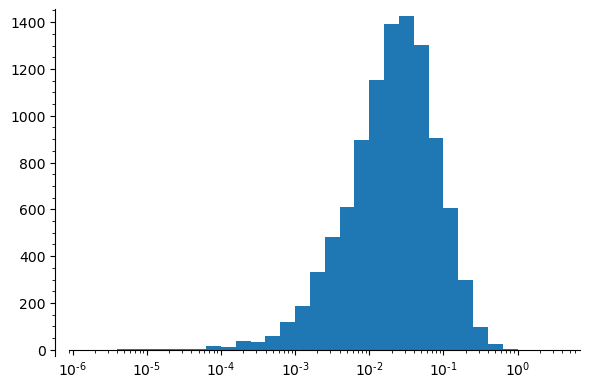

In [17]:
histogram(dets, bins = [10.0^r for r in srange(-6.0, 1.0, 0.2)], scale = "semilogx", linewidth = 0)

### Histogram of sigmas

In [18]:
%%time
sigmas = sigmaEn(allCEVs, 0.05)

CPU times: user 7.44 s, sys: 29.5 ms, total: 7.47 s
Wall time: 7.46 s


In [19]:
sigmas[:10]

[0.12887504928843332,
 0.14747545236517476,
 0.14728025469896638,
 0.11905994187181382,
 0.15594666803223672,
 0.23863867590732227,
 0.19325708137039507,
 0.12088079430261713,
 0.243029626259606,
 0.10542483632642266]

In [20]:
sum(sigmas) / len(sigmas) # average sigma (quenched)

0.1378163222989422

In [21]:
(min(sigmas), max(sigmas))

(0.05161850479558082, 0.3825240626525839)

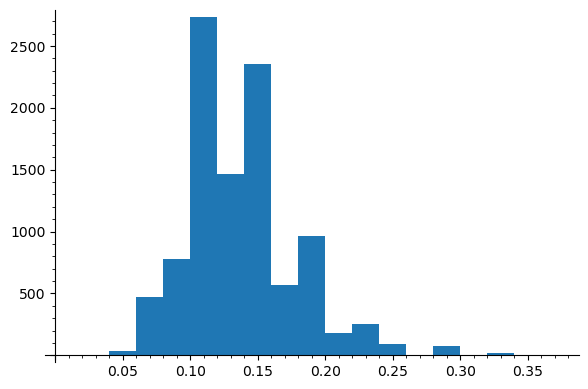

In [22]:
histogram(sigmas, bins = [r for r in srange(0.0, 0.4, 0.02)], linewidth = 0)

### Sigma reweighting

In [23]:
def sigVqm(allCEVs, maxNf, qmMin, qmMax, qmStep):
    sigqm = [[] for i in range(maxNf + 1)]
    for qm in srange(qmMin, qmMax, qmStep):
        dets = detEnMax1(allCEVs, qm)
        sigmas = sigmaEn(allCEVs, qm)
        for Nf in range(maxNf + 1):
            detNf = [d**Nf for d in dets]
            sumdetNf = sum(detNf)
            sigdetNf = [sigmas[i] * detNf[i] / sumdetNf for i in range(len(sigmas))]
            sigqm[Nf].append([qm, sum(sigdetNf)])
    return sigqm

In [24]:
%%time
sigqm = sigVqm(allCEVs, 2, 0.005, 0.151, 0.005)

CPU times: user 6min 43s, sys: 111 ms, total: 6min 43s
Wall time: 6min 43s


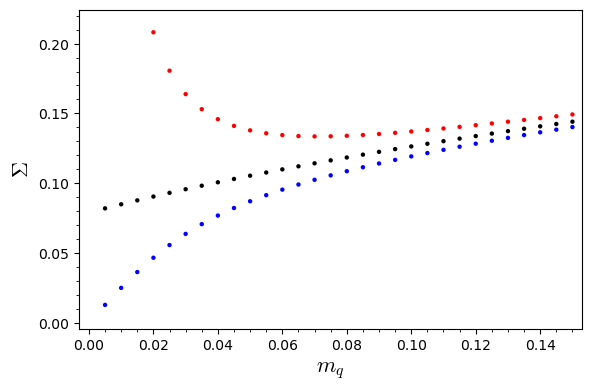

In [25]:
p0 = list_plot(sigqm[0], color = "red")
p1 = list_plot(sigqm[1], color = "black")
p2 = list_plot(sigqm[2], color = "blue")
show(p0 + p1 + p2, xmin = 0.0, ymin = 0.0, ymax = 0.22, frame = True, axes = False,
    axes_labels = ["$m_q$", r"$\Sigma$"])

In [26]:
# correction for beta = 4, i.e. g = 1/2
gsigqm = [[[sigqm[j][i][0] * 2, sigqm[j][i][1] * 2] for i in range(len(sigqm[j]))] for j in range(len(sigqm))]

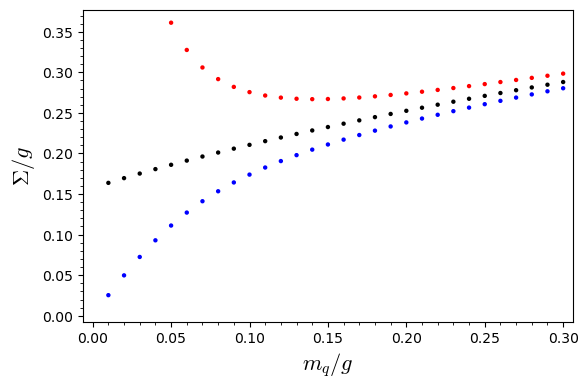

In [27]:
p0 = list_plot(gsigqm[0], color = "red")
p1 = list_plot(gsigqm[1], color = "black")
p2 = list_plot(gsigqm[2], color = "blue")
show(p0 + p1 + p2, xmin = 0.0, ymin = 0.0, ymax = 0.37, frame = True, axes = False,
    axes_labels = ["$m_q / g$", r"$\Sigma / g$"])

## Sigma - cumulative plots

### 1 flavor

In [28]:
%%time
dets = detEnMax1(allCEVs, 0.05)

CPU times: user 6.19 s, sys: 46 µs, total: 6.19 s
Wall time: 6.19 s


In [29]:
%%time
sigmas = sigmaEn(allCEVs, 0.05)

CPU times: user 7.14 s, sys: 73 µs, total: 7.14 s
Wall time: 7.14 s


In [30]:
sumdet1 = sum(dets)
sumdet1

417.46956643631773

In [31]:
sigdet1 = [sigmas[i] * dets[i] / sumdet1 for i in range(len(sigmas))]

In [32]:
sum(sigdet1)

0.10531380923744627

In [33]:
(min(sigdet1), max(sigdet1))

(5.105359002428121e-09, 0.0001236461503917912)

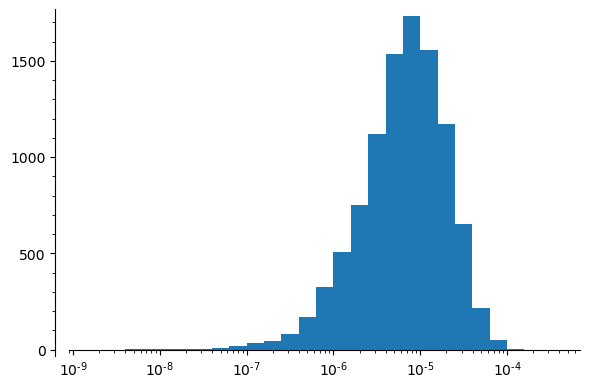

In [34]:
histogram(sigdet1, bins = [10.0^r for r in srange(-9, -3, 0.2)], scale = "semilogx", linewidth = 0)

In [35]:
sigdet1[:10]

[4.694390106584876e-06,
 6.976666257646854e-06,
 3.4397963204269235e-06,
 7.06012474503067e-06,
 3.105502654930661e-06,
 1.1105404996902633e-06,
 2.728349977093357e-06,
 5.3184525748769045e-06,
 1.306396381522002e-07,
 1.690971955541165e-05]

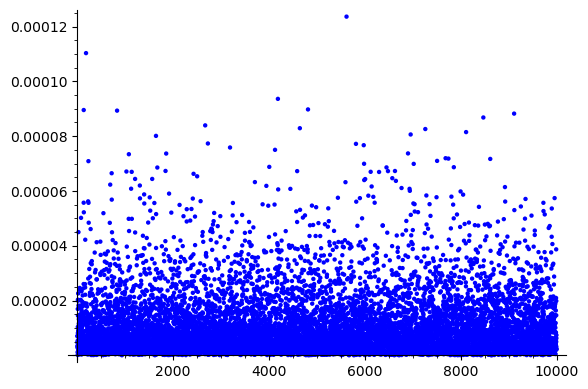

In [36]:
list_plot(sigdet1)

In [37]:
sigdet1.sort(reverse = True)

In [38]:
sigdet1[:10]

[0.0001236461503917912,
 0.00011032430239328435,
 9.361857668311222e-05,
 8.97646443893398e-05,
 8.954190264587335e-05,
 8.932363039526282e-05,
 8.823614784466048e-05,
 8.681699600251799e-05,
 8.393848149572989e-05,
 8.290597047126703e-05]

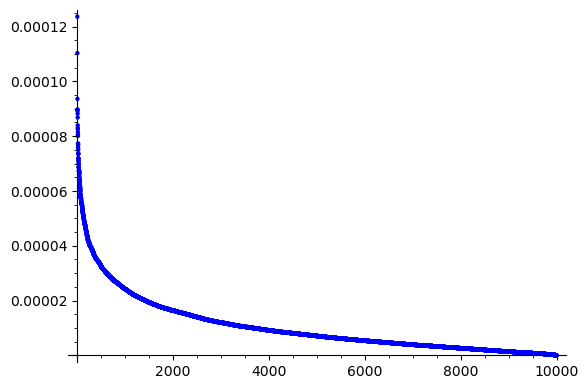

In [39]:
list_plot(sigdet1)

In [40]:
a = [i for i in range(9)]
a

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [41]:
sum(a)

36

In [42]:
[(i, sum(a[:i])) for i in range(1, len(a) + 1)]

[(1, 0), (2, 1), (3, 3), (4, 6), (5, 10), (6, 15), (7, 21), (8, 28), (9, 36)]

In [43]:
csigdet1 = [sum(sigdet1[:i]) for i in range(1, len(sigdet1) + 1)]

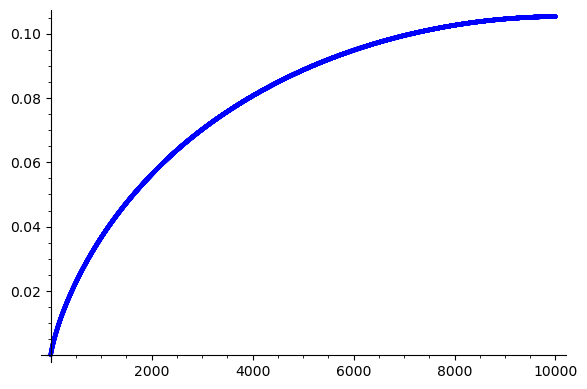

In [44]:
list_plot(csigdet1)

### 2 flavors

In [45]:
det2 = [d**2 for d in dets]

In [46]:
sumdet2 = sum(det2)
sumdet2

50.30077351846412

In [47]:
sigdet2 = [sigmas[i] * det2[i] / sumdet2 for i in range(len(sigmas))]

In [48]:
sum(sigdet2)

0.08698086336108667

In [49]:
sigdet2.sort(reverse = True)

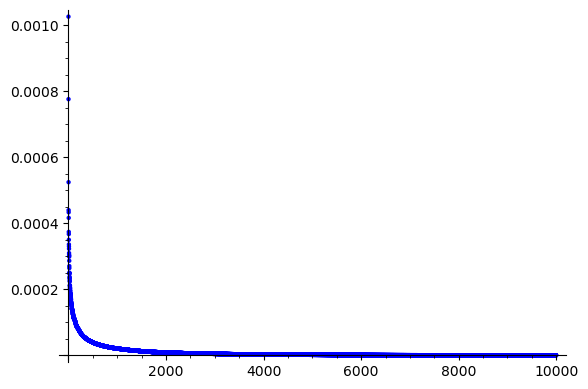

In [50]:
list_plot(sigdet2)

In [51]:
csigdet2 = [sum(sigdet2[:i]) for i in range(1, len(sigdet2) + 1)]

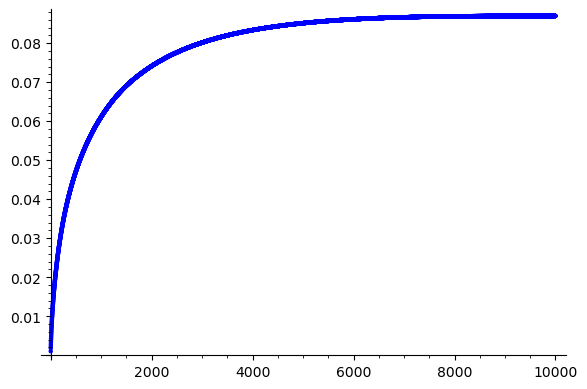

In [52]:
list_plot(csigdet2)

### 4 flavors

In [53]:
det4 = [d**4 for d in dets]
sumdet4 = sum(det4)
sumdet4

4.86183034682638

In [54]:
sigdet4 = [sigmas[i] * det4[i] / sumdet4 for i in range(len(sigmas))]
sum(sigdet4)

0.06531087963147375

In [55]:
sigdet4.sort(reverse = True)

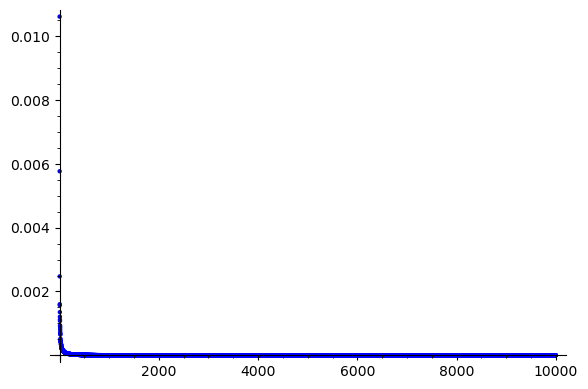

In [56]:
list_plot(sigdet4)

In [57]:
csigdet4 = [sum(sigdet4[:i]) for i in range(1, len(sigdet4) + 1)]

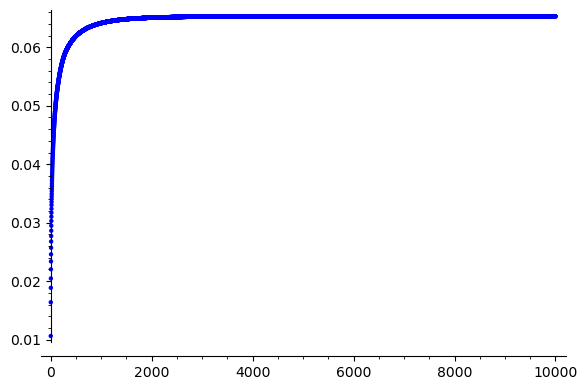

In [58]:
list_plot(csigdet4)

### Any number of flavors

In [59]:
def cumSigma(sigmas, dets, Nf):
    detNf = [d**Nf for d in dets]
    sumdetNf = sum(detNf)
    sigdetNf = [sigmas[i] * detNf[i] / sumdetNf for i in range(len(sigmas))]
    sumSDNf = sum(sigdetNf)
    sigdetNf.sort(reverse = True)
    csigdetNf = [sum(sigdetNf[:i]) / sumSDNf for i in range(1, len(sigdetNf) + 1)]
    s50 = len([cs for cs in csigdetNf if cs <= 0.50])
    s90 = len([cs for cs in csigdetNf if cs <= 0.90])
    s99 = len([cs for cs in csigdetNf if cs <= 0.99])
    print("%2d  %9.7f %5d %5d %5d " % (Nf, sumSDNf, s50, s90, s99))
    return list_plot(csigdetNf)

Nf    sigma     50%   90%   99%
 1  0.1053138  1789  5992  8791 
 2  0.0869809   412  2611  5974 
 4  0.0653109    16   275  1325 
 6  0.0561419     1    23   203 


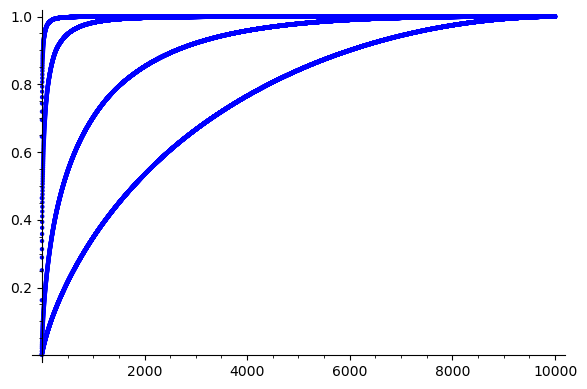

In [60]:
print("Nf    sigma     50%   90%   99%")
print("===============================")
cumSigma(sigmas, dets, 1) + cumSigma(sigmas, dets, 2) + cumSigma(sigmas, dets, 4) + cumSigma(sigmas, dets, 6)

*Hip, 2023-08-06*